In [1]:
import numpy as np
from numpy import linalg as la
from numpy.random import RandomState
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn import decomposition
from skimage.util import random_noise
from skimage import img_as_float
from time import time
import scipy.fftpack as fp
import pywt
import math

In [2]:
def RSME(gn, g):
    gn = gn.flatten()
    g = g.flatten()
    N = gn.size
    a = sum(np.square(abs(gn-g)))
    r = math.sqrt((1/N**2)*a)
    return r


def svd_denoise(img,r):
    u, sigma, vt = la.svd(img)
    h, w = img.shape[:2]
    h1 = int(h * r) 
    sigma1 = np.diag(sigma[:h1],0) 
    u1 = np.zeros((h,h1), float)
    u1[:,:] = u[:,:h1]
    vt1 = np.zeros((h1,w), float)
    vt1[:,:] = vt[:h1,:]
    return u1.dot(sigma1).dot(vt1)

In [3]:
# generate all the faces vector, need to reshape
rng = RandomState(0)
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
original_faces = img_as_float(dataset.data)
image_shape = (64, 64)
n_samples, n_features = original_faces.shape

# apply random noise to each of the faces vector
noise_faces = np.zeros_like(original_faces)
for i in range(len(original_faces)):
    noise_faces[i] = random_noise(original_faces[i], var=0.005)

x1 = original_faces[6]
noise_x1 = noise_faces[6]



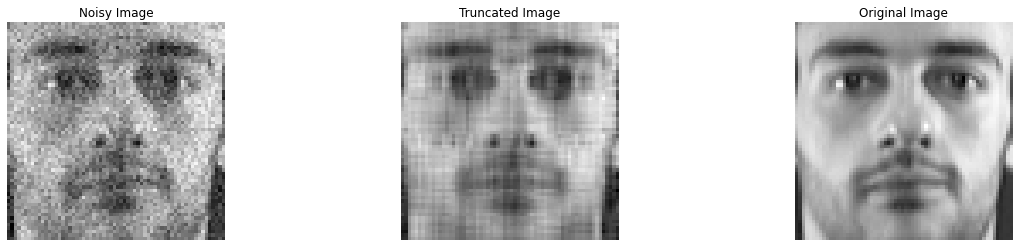

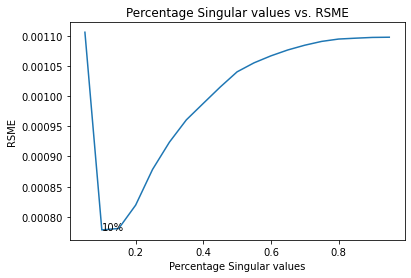

In [8]:
# calculate the RSME betweeen original image and noise image
r = RSME(x1,noise_x1)
r_array = []
x_array = []
xl = []
for i in range(19):
    denoise_x1 = svd_denoise(np.reshape(noise_x1, image_shape), (i+1)*0.05)
    r_array.append(RSME(x1,denoise_x1))
    x_array.append((i+1)*0.05)

r_min = min(r_array)
x_min = x_array[r_array.index(r_min)]
show_min = str(int(x_min*100)) + '%'


denoise_x1 = svd_denoise(np.reshape(noise_x1, image_shape), x_min)
plt.figure(figsize=(20,4))
plt.subplot(1,3,3),plt.imshow(np.reshape(x1,image_shape)), plt.axis('off'), plt.set_cmap('gray'), plt.title('Original Image')
plt.subplot(1,3,1),plt.imshow(np.reshape(noise_x1,image_shape)), plt.axis('off'), plt.set_cmap('gray'), plt.title('Noisy Image')
plt.subplot(1,3,2),plt.imshow(np.reshape(denoise_x1,image_shape)), plt.axis('off'), plt.set_cmap('gray'), plt.title('Truncated Image')
plt.show()


plt.plot(x_array,r_array)
plt.title("Percentage Singular values vs. RSME")
plt.xlabel("Percentage Singular values")
plt.ylabel("RSME")
plt.annotate(show_min,xy=(x_min,r_min),xytext=(x_min,r_min))
plt.show()




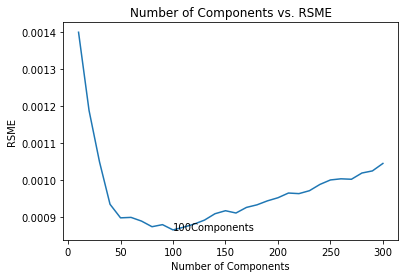

In [23]:
r_array = []
x_array = []
for i in range(30):
    n_components = (i+1)*10 # 256
    estimator = decomposition.PCA(n_components=n_components, svd_solver='randomized', whiten=True)
    faces_recons = estimator.inverse_transform(estimator.fit_transform(noise_faces)) #.T #+ mean_face #.T
    r_array.append(RSME(x1,faces_recons[6]))
    x_array.append(n_components)

r_min = min(r_array)
x_min = x_array[r_array.index(r_min)]
show_min = str(x_min) + 'Components'
plt.plot(x_array,r_array)
plt.title("Number of Components vs. RSME")
plt.xlabel("Number of Components")
plt.ylabel("RSME")
plt.annotate(show_min,xy=(x_min,r_min),xytext=(x_min,r_min))
plt.show()
# n_components = 100 # 256
# estimator = decomposition.PCA(n_components=n_components, svd_solver='randomized', whiten=True)
# print("Extracting the top %d PCs..." % (n_components))
# t0 = time()
# faces_recons = estimator.inverse_transform(estimator.fit_transform(noise_faces)) #.T #+ mean_face #.T
# train_time = (time() - t0)
# print("done in %0.3fs" % train_time)

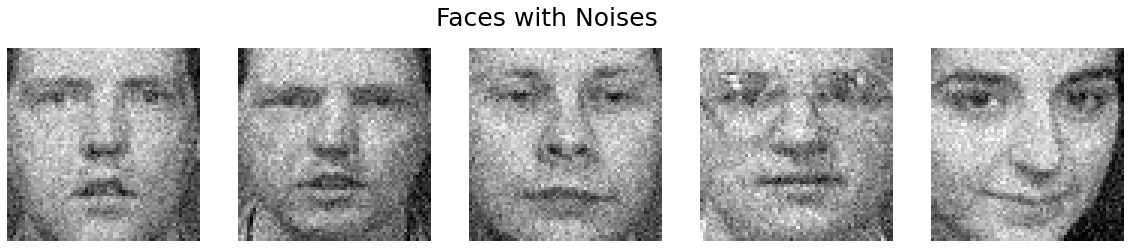

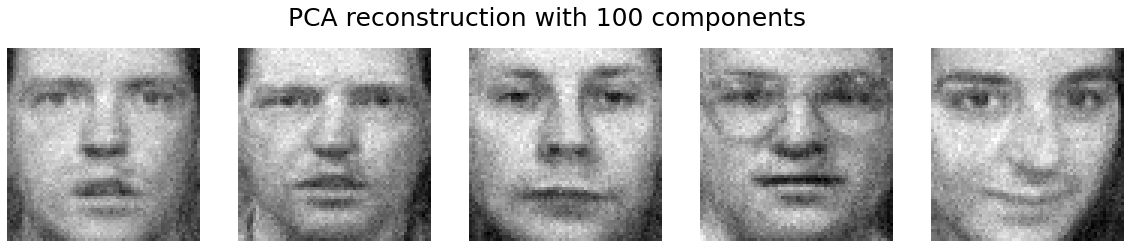

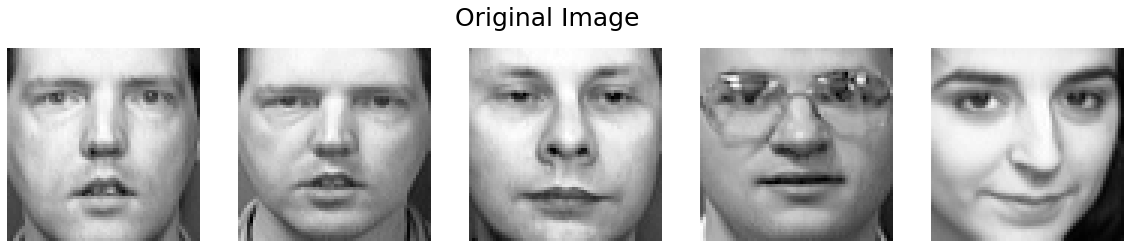

In [10]:
indices = np.random.choice(n_samples, 5, replace=False)

plt.figure(figsize=(20,4))
for i in range(len(indices)):
    plt.subplot(1,5,i+1), plt.imshow(np.reshape(noise_faces[indices[i],:], image_shape)), plt.axis('off'), plt.set_cmap('gray')
plt.suptitle('Faces with Noises', size=25)
plt.show()

plt.figure(figsize=(20,4))
for i in range(len(indices)):
    plt.subplot(1,5,i+1), plt.imshow(np.reshape(faces_recons[indices[i],:], image_shape)), plt.axis('off'), plt.set_cmap('gray')
plt.suptitle('PCA reconstruction with {} components'.format(n_components), size=25)
plt.show()

plt.figure(figsize=(20,4))
for i in range(len(indices)):
    plt.subplot(1,5,i+1), plt.imshow(np.reshape(original_faces[indices[i],:], image_shape)), plt.axis('off'), plt.set_cmap('gray')
plt.suptitle('Original Image', size=25)
plt.show()

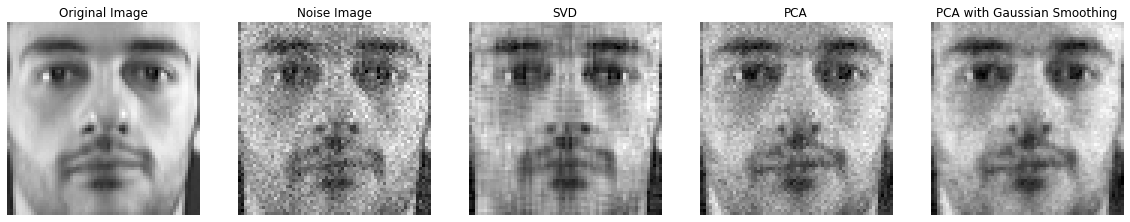

0.0011135182723177584 0.0007553598875026018 0.0008715374027699496


In [11]:
from scipy.ndimage import gaussian_filter
denoise_x1_pca = np.reshape(faces_recons[6], image_shape)
plt.figure(figsize=(20,4))
plt.subplot(1,5,1),plt.imshow(np.reshape(x1,image_shape)), plt.axis('off'), plt.set_cmap('gray'), plt.title('Original Image')
plt.subplot(1,5,2),plt.imshow(np.reshape(noise_x1,image_shape)), plt.axis('off'), plt.set_cmap('gray'), plt.title('Noise Image')
plt.subplot(1,5,3),plt.imshow(np.reshape(denoise_x1,image_shape)), plt.axis('off'), plt.set_cmap('gray'), plt.title('SVD')
plt.subplot(1,5,4),plt.imshow(np.reshape(denoise_x1_pca,image_shape)), plt.axis('off'), plt.set_cmap('gray'), plt.title('PCA')
plt.subplot(1,5,5),plt.imshow(gaussian_filter(np.reshape(denoise_x1_pca,image_shape), sigma=0.5)), plt.axis('off'), plt.set_cmap('gray'), plt.title('PCA with Gaussian Smoothing')
plt.show()

r1 = RSME(x1,noise_x1)
r2 = RSME(x1,denoise_x1)
r3 = RSME(x1,denoise_x1_pca)
print(r1,r2,r3)

# plt.plot(x_array,r_array)
# plt.title("Percentage Singular values vs. RSME")
# plt.xlabel("Percentage Singular values")
# plt.ylabel("RSME")
# plt.annotate(show_min,xy=(x_min,r_min),xytext=(x_min,r_min))
# plt.show()